In [17]:
import numpy as np
import matplotlib.pyplot as plt
import unittest
import seaborn as sns
sns.set_style('darkgrid')
from sympy import symbols, solve
from scipy.optimize import linprog


This is an example of a product portfolio choice problem optimizing the following problem of which a firm is able to produce n different products subject to a set of linear technological constraints and which maximizes a linear profit function:

$$
\max(\pi x) \text{ subject to } Ax \le b,
$$

where $ \pi $ denotes the vector of per product unit profits, and matrix $ A $ together with the
vector $ b $ gives the set of technological constraints.


#### An object orientated approach will be used to describe the space of the problem. 

In [18]:

class production_portfolio:
    
    '''This class describes the model of optimal product portfolio choice
       It takes in constraints and prices with the ability to remove each'''

    prices = []
    #The constraints are added as a class attribute, NOT an instance attribute
    #To delete constraints, must use the remove_constraint method individually or the reset method to remove all
    a_matrix = []
    b_matrix = []
    temp = []
    
    def __init__(self, n):
        '''Initialize the optimal product portfolio choice model'''
        #n is the number of constraints (not including non-negativity constraints)
        #Took out current specification (label) of the model - not needed for our model
        self.n = n

    def __repr__(self):
        '''String representation for the optimal product portfolio choice model'''

        return ('''These are the constraints: \nA:{}\nb:{}\nThese are the prices: {}\nThere are {} constraints
                '''.format(self.a_matrix, self.b_matrix, self.prices, 
                                                      self.nr_constraints()))
        
    def set_prices(self,p):
        '''Set product prices: p is list of nparray of length n'''
        p = np.array(p)
        self.prices.append(list(abs(p)))
        return self.prices

    def add_constraint(self,coef,b):
        '''
        Adds the coefficients and b values to the model. Does not check if it is feasible. 
        Run consistency_check below to check feasibility.
        
        '''
        self.a_matrix.append(coef)
        self.b_matrix.append(b)
        return self.a_matrix, self.b_matrix

    def inception(matrix):
        '''Converts nested lists to a one-nested list(i.e. a matrix form)
           [[[1,5], [4,6]]] -> [[1,5], [4,6]]. Needs to be in this later form for below function'''
        if isinstance(matrix, list):
            temp.append(matrix)
            matrix = matrix[0]
            inception(matrix)
        if isinstance(matrix, int):
            return temp[-1]
        return temp[-2]

    def remove_constraint(self,j):
        '''Removes the jth row constraint of the model'''
        self.a_matrix = inception(self.a_matrix)
        self.a_matrix = np.delete(self.a_matrix, j, axis=0)
        self.b_matrix = np.delete(self.b_matrix, j, axis=0)
        #If prices not equal to the number of products, this sets the remaining equal to 0. Might not be needed
        if len(self.prices)>0:
            self.prices = np.delete(self.prices,j)
            return self.a_matrix, self.b_matrix, self.prices
        return self.a_matrix, self.b_matrix


    def nr_constraints(self):
        '''Number of constraints in the current model'''
        return (np.array(self.a_matrix).shape[0])
    
    @classmethod
    def reset(self):
        '''Removes all the constraints in the model from the class attribute'''
        self.a_matrix = []
        self.b_matrix = []
        self.prices = []

#### A consistency check for the problem needs to be added. How do you tell if a solution exists within the constraints?

In [19]:
upperbound = 20
grid = np.linspace(0, upperbound, 50) 
hypercube = [] #This is the space of x
#Each element in grid is multipled by all the other elements in grid to create our hypercube
#Not a proper hypergrid as the dimensions are (2500,2) but is an unstack of each dimension onto a column
for i in grid: 
    for j in grid: 
        hypercube.append([j,i])

hypercube = np.array(hypercube)
x = hypercube

In [20]:
def consistency_check(a, b,x, verbose=False):
    
    '''Checks if the system of inequality constraints in the model is consistent'''
    # x is a 2500x2 matrix, a is the constraint matrix
    #Each element in x is checked against the equation a*x <= b
    #The first constraint in which this equation is not true, it exits out of the loop and goes to the next x. 
    #Repeats until it finds an x that meets all the constraints, then exits the loop with True else False 
    for i in range(len(x)):
        for j in range(len(a)):
            if not a[j]@x[i] <= b[j]:
                break
            if j == (len(a)-1):
                if verbose: return print("This is feasible at: \ni: {}, a: {}, b: {}, j:{}".format(i, a[j], b[j], j))
                else: return True
    if verbose:
        return print("This is not feasible")
    else:
        return False

In [21]:

class TestDemo(unittest.TestCase):
    
    def test1(self):
        '''general feasible constraints'''
        a = [[1,1], [3,2],[-1,0],[0,-1]] 
        b = [2,5,0,0]
        test = consistency_check(a,b,x)
        self.assertTrue(test)
    
    def test2(self):
        '''general feasible constraints'''
        a = [[1,1], [1,0], [-1,0], [0,-1]]
        b = [1,0,0,0]
        test = consistency_check(a,b,x)
        self.assertTrue(test)
    
    def test3(self):
        '''non-feasible constraints with given x'''
        a = [[1,1], [3,2], [-1, 1], [-1,0], [0,-1]]
        b = [2,5,-5,0,0]
        test = consistency_check(a,b,x)
        self.assertFalse(test) #This is not feasible and should return False
        
    def test4(self):
        '''non-feasible constraints with given x'''
        a = [[-0.5, -1],[1,1],[-1,0],[0,-1]]
        b = [-12,10,0,0]
        test = consistency_check(a,b,x)
        self.assertFalse(test) #This is not feasible and should return False
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

....
----------------------------------------------------------------------
Ran 4 tests in 0.061s

OK


## A Graphical Representation of the linear programming problem

In [22]:

class graph_from_matrix:
    
    def __init__(self, matrix, x, n, contour=None, nonneg=True, xlim=10,ylim=10, verbose=False, solve=False, 
                 geq=None, c = None, overlap = False, optimal_level = False, hide_point=False):
        self.matrix = matrix #Matrix of constraints. Must include non-negativity constraints in here.
        self.x = x #Space of solutions
        self.n = n # Number of constraints to solve
        self.nonneg = nonneg #Automatically fills in nonnegativity constraints if true
        self.xlim = xlim #Sets limits on x
        self.ylim = ylim #Sets limits on y
        self.verbose=verbose
        self.solve = solve #If constraints or objective functions are given, can calculate the optimal point
        self.geq = geq #The shaded region between the constraint and axis is flipped for a particular constraint
        self.contour = contour # True or False
        self.c = c #Vector of prices/objective fuction
        self.optimal_level = optimal_level #Given a specific objective function, shows the specific contour plot
        self.overlap = overlap #Visualization tool to view price contour plot if it overlaps constraint
        self.hide_point = hide_point 
        
    def equation(self, matrix):
        '''Takes in a matrix of A and b values, where the last column is the solution (b vector) 
        and finds and equation to solve'''
        # Treats x and y as symbols and not variables
        x_symb = symbols('x'); y_symb=symbols('y') 
        expr = []
        #Converts the matrices back into equations to solve 
        for eq in range(len(self.matrix)): 
            expr.append(self.matrix[eq][0]*x_symb 
                        + self.matrix[eq][1]*y_symb 
                        - self.matrix[eq][2])

        lines = []
        # Solves the equations for y for each equation found above
        for equation in expr: 
            lines.append(solve(equation, y_symb))
        
        if self.verbose: print("These are the equations to solve: {}".format(lines[:-2]))
        # Takes off the last two values which are the non-negativity constraints. They are 0
        return lines[:-2] 
    
    def yvalue(self):
        '''Solves for y given the above equation and the x's formed from the meshed grid'''
        #Calls above function with the given instanced matrix
        equations = self.equation(self.matrix)
        x = self.x #Needed to evaluate the type str below
        y = []
        #Evaluates y for each equation
        for i in equations:
            y.append(eval(str(i[0])))
        # Dimensions equal to amount of constraints solved. Doesn't solve non-negativity constraints
        return y 


    def plot(self):
        '''Plots the equations, the mesh grid, contour plots and optimal point/s'''

        fig, ax1 = plt.subplots()
        plt.rcParams['figure.figsize'] = [12, 8]
        
        #Only used if the constraint overlaps a specific contour plot given by a price vector
        #Plots the overlapped constraint with a small linewidth and the rest as normal
        if self.overlap:
            for i in range(len(self.yvalue())):
                    if i == 2:
                        plt.plot(self.x, self.yvalue()[i], color='black', linewidth=0.01)
                    else:
                        plt.plot(self.x, self.yvalue()[i], color='black')
        else:
            for i in self.yvalue():
                plt.plot(self.x, i, color='black')
                
        #Fills in each constraint as necessary, geq flips the fill to the opposite side
        #Colours in the feasible set given the constraints
        for i in range(len(self.yvalue())):
            if i == self.geq:
                ax1.fill_between(self.x,max(self.yvalue()[i]),self.yvalue()[i],alpha=0.33,color='g') 
            else:
                ax1.fill_between(self.x,0,self.yvalue()[i],alpha=0.33,color='g')
        
        #Plots the mesh grid, each dimension of a column is a dimension of a hypergrid. In this case = square   
        plt.scatter(x[:,0], x[:,1], s=3)

        # Plots lines on axis if non-negativity constraint is needed
        if self.nonneg: 
            plt.plot([0]*self.ylim,range(0,self.ylim),color='black')
            plt.plot(range(0,self.xlim),[0]*self.xlim,color='black')
        
        #Maximum x and y values are equal to the maximum of the constraint matrices
        plt.xlim(0,(self.matrix).max())
        plt.ylim(0,(self.matrix).max()) 
        plt.xlabel('x')
        plt.ylabel('y')
        
        #If the objective function and constraints exists, the equation is solved for the optimal point and graphed
        #If the value of the optimal solution does not exist in our space of values (meshgrid)
        #the nearest point that exists to our optimal solution is found and also graphed
        if self.solve:
            point = solver(n=2,c=c,A=A,b=b)['x']
            if not self.hide_point:
                plt.plot(point[0],point[1],'ro')
                plt.plot(nearest(hypercube, point)[0], nearest(hypercube, point)[1], 'bo')
            
        if self.contour:
            X,Y = np.meshgrid(grid, grid)
            Z = self.contour[0]*X + self.contour[1]*Y
            
            #If a specific objective function is given, this graphs only that contour line
            if self.optimal_level:
                self.optimal_level = self.contour[0]*point[0]+self.contour[1]*point[1]
                ax1.contour(X,Y,Z, levels=[self.optimal_level],colors='r', linewidths=3)
            
            #If no specific objective function, maps out a variety of contours
            else:
                ax1.contour(X,Y,Z, levels=30,colors='r')
        return plt.show()

### Example problem with a given a, b

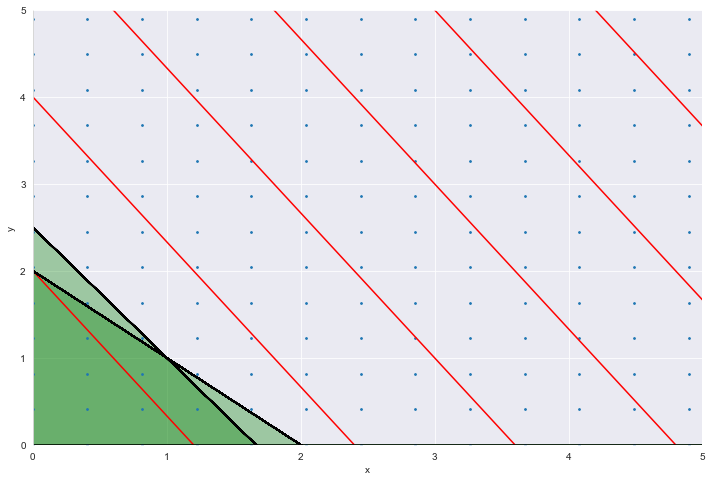

In [23]:
x = hypercube
a = np.array([[1,1], [3,2],[-1,0],[0,-1]]) #Constraints/coefficients
b = np.array([2,5,0,0]).reshape(4,1) #Technological constraints
matrix = np.append(a,b,1) 

n = 2
obj = graph_from_matrix(matrix, x[:,0], n, contour=[5,3])
obj.plot()

In [24]:
#Find all intersection points of the line segments

def intersection_points(n,*args):
    
    x_points = []
    y_points = []
    for i in range(len(args)):
        for j in range(len(args)):
            if i != j and j >= i:
                #print("Solving for: {} = {}".format(args[i], args[j]))
                x_points.append(solve(args[i]-args[j],symbols('x')))
    
    for i in range(len(x_points)):
        x_points[i] = float(x_points[i][0])

    if n == 3:
        temp = x_points.copy()
        x_points[2] = temp[1]
        x_points[1] = temp[2]
    #print(x_points, args, sep='\n')
    for x_values, equation in zip(x_points,args):
        x = x_values
        y_points.append(eval(str(equation)))
    
    #return x_points
    return list(zip(x_points, y_points))
    

In [25]:
intersection = intersection_points(2, obj.equation(matrix)[0][0], obj.equation(matrix)[1][0])
print("The intersection point of the above graph is x: {}, y: {}".format(intersection[0][0], intersection[0][1]))

The intersection point of the above graph is x: 1.0, y: 1.0


## Given a price vector, what is the optimal value?
### Example:

Let $ n=2 $ and the goods production technology
is restricted by

$$
\begin{cases}
y - x  &\le& 6, \\
2x - y &\le&12,
\end{cases}
$$

In addition, there is a resource constraint given by $ x + 2.5y \le 16 $.

Finally, let profit be given by $ \pi(x,y) = 3y + 5x $.

In [26]:
#Model object created within the function itself - mixing OOP and functional programming
def solver(n, c, A, b, method='simplex'):
    ''' Uses linprog to solve optimal production portfolio
    n is number of goods
    c = the profit function
    A is the matrix of constraints
    B is the technology constraint'''
    f = production_portfolio(n)
    for i in range(len(A)):
        f.add_constraint(A[i],b[i]) 
    A = f.a_matrix
    b = f.b_matrix
    f.prices = c
    c = np.array(c)
    res = linprog(c, A_ub = A, b_ub = b, method=method)  
    return res

In [27]:
# Finding the optimal product portfolio given constraints and prices
#Constraints
A = [[-1, 1],[2, -1],[1, 2.5],[-1, 0],[0, -1]]
b = [6,12,16,0,0]
#Prices
c = [-5,-3]
f = production_portfolio(3)
point = solver(n=3,c=c,A=A,b=b)['x']
f.prices = c
f

These are the constraints: 
A:[[-1, 1], [2, -1], [1, 2.5], [-1, 0], [0, -1]]
b:[6, 12, 16, 0, 0]
These are the prices: [-5, -3]
There are 5 constraints
                

In [28]:
print('This is the optimal solution given by the above constraints\nx:{}\ny:{}'.format(round(point[0],3), 
                                                                                   round(point[1],3)))

This is the optimal solution given by the above constraints
x:7.667
y:3.333


### If it's a discrete product portfolio, the solution might not exist within our space of values (the grid/hypercube). Need to find the feasible point closest to the optimal solution


In [29]:

def nearest(x, optimal_points, verbose=False):
        '''As the product space may not be continious, the closest value to the optimal solution is found in our grid'''
        #Takes the absolute difference between the optimal point and all the values of the mesh grid
        #Finds the index of the smallest difference
        index = ((np.abs(x[:,0] - optimal_points[0])) + (np.abs(x[:,1] - optimal_points[1]))).argmin()
        
        feasible = True
        #For that value, see if it is feasible. If not feasible, delete that value and redo fnding the nearest point
        while feasible:
            # If this evaluates to True, feasible = false. exits loop
            feasible = not (A@np.array(x[index]) <= b.T).all() 
            if not feasible: 
                break
            if verbose: print('Deleted these: {}'.format(x[index]))
            x = np.delete(x, index, 0)
            index = ((np.abs(x[:,0] - optimal_points[0])) + (np.abs(x[:,1] - optimal_points[1]))).argmin()
        
        return x[index]

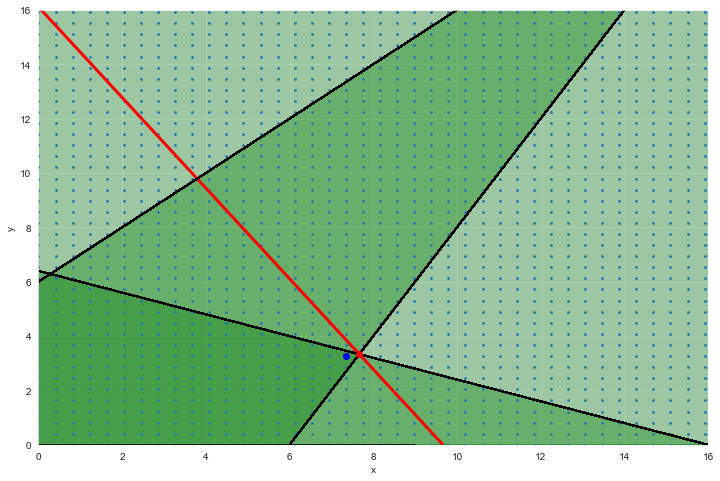

In [30]:
#production_portfolio(2).reset()
x = hypercube
#New constraints
a = np.array([[-1, 1],[2, -1],[1, 2.5],[-1, 0],[0, -1]])
b = np.array([6,12,16,0,0]).reshape(5,1)
#Added together into a matrix
matrix = np.append(a,b,1)
#Price vector is negative as it is a maximization problem and by default linprog solves for minimization
c = [-5,-3]
contour = list(np.array(c)*-1)
n = 3

#Matrix = constriants, x=[:,0] hypercube, n = 3, find the optimal point
obj = graph_from_matrix(matrix, x[:,0], n, solve=True, geq=1, 
                        contour=contour, c=c, optimal_level=True)
obj.plot()

In [31]:
intersection = intersection_points(3, obj.equation(matrix)[0][0], obj.equation(matrix)[1][0], obj.equation(matrix)[2][0])
print('''The intersection points of the above graph are the following: 
         \nx1: {} y1: {}\nx2: {} y2: {}\nx3" {} y3: {}'''.format(intersection[0][0], intersection[0][1], 
                                                                 intersection[1][0], intersection[1][1],
                                                                 intersection[2][0], intersection[2][1]))

The intersection points of the above graph are the following: 
         
x1: 18.0 y1: 24.0
x2: 7.666666666666667 y2: 3.333333333333334
x3" 0.2857142857142857 y3: 6.2857142857142865


### Short Analysis on the given price ratio

### Example 1: Price Ratio at 2x:5y


Due to prices always being positive, the optimal bundle is monotonic and always limited by the constraints. If the price vector is parallel to the constraint $ x + 2.5y \le 16 $, the optimal bundle will be any point along this constraint between the two extreme points of (7.667, 3.333) and (0.286, 6.286)

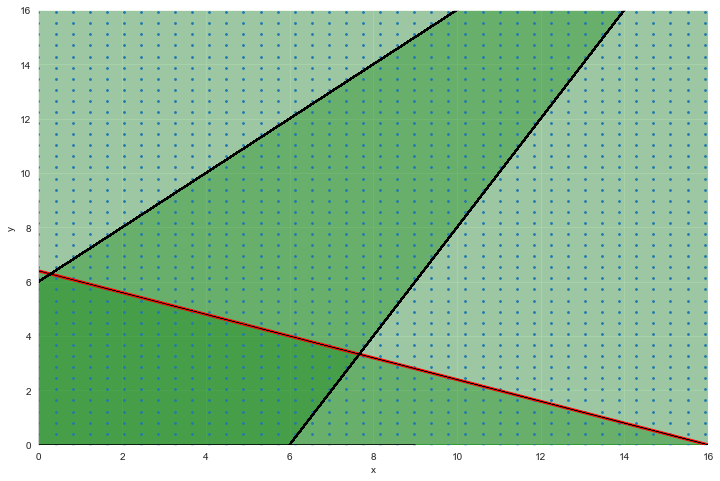

In [32]:
x = hypercube
a = np.array([[-1, 1],[2, -1],[1, 2.5],[-1, 0],[0, -1]])
b = np.array([6,12,16,0,0]).reshape(5,1)
matrix = np.append(a,b,1)
contour = [3,7.5]
c = [-3,-7.5]

n = 3
obj = graph_from_matrix(matrix, x[:,0], n, solve=True, geq=1, 
                        contour=contour, c=c, optimal_level=True, overlap=True, hide_point=True)
obj.plot()

### Example 2: Ratio lower than 2:5 

In this example, we pick an objective function where the ratio of price x to price y is marginally smaller than 2:5. We can see that the flatter objective function means (0.286, 6.286) becomes the optimal point. 

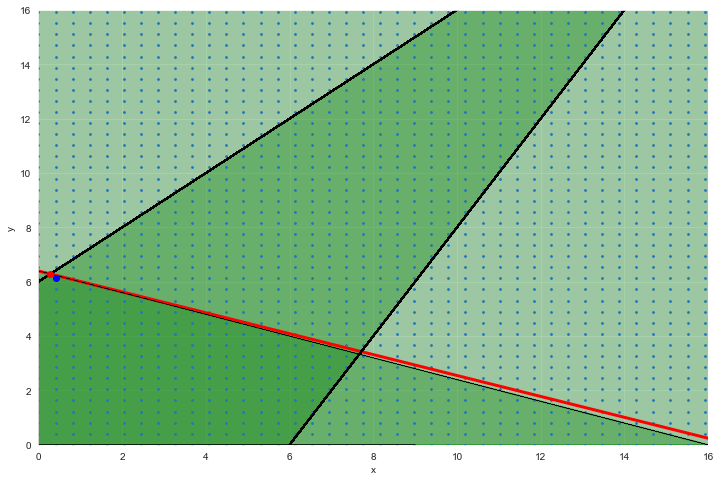

In [33]:
x = hypercube
a = np.array([[-1, 1],[2, -1],[1, 2.5],[-1, 0],[0, -1]])
b = np.array([6,12,16,0,0]).reshape(5,1)
matrix = np.append(a,b,1)
contour = [5,13]
c = [-5,-13]

n = 3
obj = graph_from_matrix(matrix, x[:,0], n, solve=True, geq=1, 
                        optimal_level=True, contour=contour, c=c, overlap=True)
obj.plot()